In [1]:
import os

import numpy as np
import cupy as cp
from himalaya.backend import set_backend
from himalaya.ridge import Ridge
from himalaya.scoring import r2_score
from matplotlib import pyplot as plt
from sklearn import config_context
from sklearn.metrics import make_scorer
from sklearn.model_selection import ValidationCurveDisplay, validation_curve

from compare_variance_residual.simulated.simulation import generate_dataset

In [2]:
def single_r2_score(y_true, y_pred, combine_func=np.mean):
    """
    Wrap himalaya's r2_score to compute a single average r2 score across targets.

    Parameters:
    - y_true (array-like): True target values.
    - y_pred (array-like): Predicted target values.
    - combine_func (callable, optional): Function to combine scores,
      e.g., np.mean, np.median. Default is np.mean.

    Returns:
    - float: A single r2 score derived from combining per-target scores.
    """
    per_target_r2 = r2_score(y_true, y_pred)  # Per-target r2 scores
    return combine_func(per_target_r2)  # Combine into a single score

In [3]:
set_backend("cupy", on_error='warn')
os.environ["SCIPY_ARRAY_API"] = "1"

feature_space_dimensions = [
    100,  # shared
    100,  # unique 0
    100,  # unique 1
]
scalars = [
    0.6, 0.3, 0.1
]
n_targets = 1000
n_samples_train = 10000
n_samples_test = 100
noise_scalar = 0.1

cv = 20
alphas = np.logspace(-4, 4, 10)

In [4]:
(Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(feature_space_dimensions, scalars, n_targets, n_samples_train,
                                                        n_samples_test, noise_scalar)

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The Ridge or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The Ridge or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `s

Train Scores (Mean R² Across Targets): [[0.96923769 0.96921486 0.96923548 0.96922964 0.96923888 0.96922922
  0.96921986 0.96921933 0.96922576 0.9692387  0.96921253 0.96921748
  0.96922207 0.96924073 0.96921784 0.96922046 0.96923369 0.96921372
  0.96921659 0.96923304]
 [0.96923769 0.96921486 0.96923548 0.96922964 0.96923888 0.96922922
  0.96921986 0.96921933 0.96922576 0.9692387  0.96921253 0.96921748
  0.96922207 0.96924073 0.96921784 0.96922046 0.96923369 0.96921372
  0.96921659 0.96923304]
 [0.96923769 0.96921486 0.96923548 0.96922964 0.96923888 0.96922922
  0.96921986 0.96921933 0.96922576 0.9692387  0.96921253 0.96921748
  0.96922207 0.96924073 0.96921784 0.96922046 0.96923369 0.96921372
  0.96921659 0.96923304]
 [0.96923769 0.96921486 0.96923548 0.96922964 0.96923888 0.96922922
  0.96921986 0.96921933 0.96922576 0.96923882 0.96921253 0.96921748
  0.96922207 0.96924073 0.96921784 0.96922046 0.96923369 0.96921372
  0.96921659 0.96923304]
 [0.96923769 0.96921486 0.96923548 0.96922964

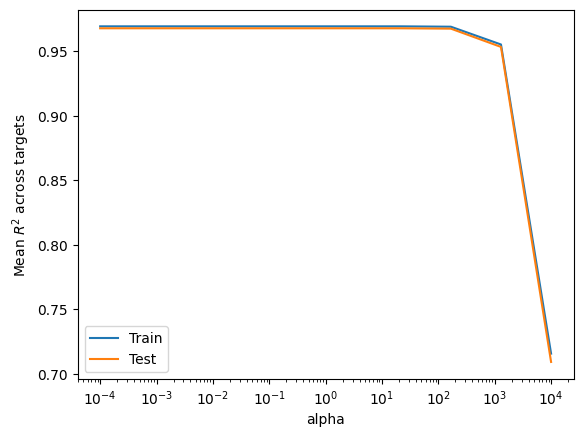

In [5]:
with config_context(array_api_dispatch=True):
    # Custom scorer (works with CuPy arrays, internally converted to NumPy)
    custom_r2_scorer = make_scorer(
        single_r2_score, combine_func=cp.mean, greater_is_better=True
    )
    param_name = "alpha"
    param_range = alphas

    # Validation curve (Xs_train remains CuPy; labels remain CuPy)
    train_scores, test_scores = validation_curve(
        Ridge(), Xs_train[0], Y_train, param_name=param_name,
        param_range=param_range, cv=cv, scoring=custom_r2_scorer
    )

    # Display results
    print("Train Scores (Mean R² Across Targets):", cp.asnumpy(train_scores))
    print("Test Scores (Mean R² Across Targets):", cp.asnumpy(test_scores))

    # ValidationCurveDisplay does not support CuPy arrays -> convert before plotting
    display = ValidationCurveDisplay(
        param_name=param_name,
        param_range=param_range,
        train_scores=cp.asnumpy(train_scores),  # Convert to NumPy for plotting
        test_scores=cp.asnumpy(test_scores),  # Convert to NumPy
        score_name=r"Mean $R^2$ across targets"
    )
    display.plot()
    plt.show()